In [2]:
import matplotlib.pyplot as plt
import pickle
import os
import numpy as np

# Calc FLOPS

In [3]:
from calc_pseudo import clean, basic_flops
B_TARGET_PANEL_WIDTH = 48

In [4]:
MAT_PATH = "./../../../synth_mats/"
mat_paths = sum([[os.path.join(dir, file) for file in files] for dir, _, files in os.walk(MAT_PATH)], [])

In [5]:
mat_flops = {}

In [6]:
for mat_path in mat_paths:
    with open(mat_path) as f:
        test_mat = clean(np.loadtxt(f))
    FLOPS_PER_PANEL = basic_flops(test_mat, B_TARGET_PANEL_WIDTH)
    
    mat_flops[mat_path.split("./../../../")[1]] = FLOPS_PER_PANEL

## Load Data

In [7]:
L1N_DIR = "./../../../logs/regpack_L1_N/synth/" # local=L1_N2, ref=L1_N3

LN2_DIR = "./../../../logs/regpack_macc/regpack_ln2/synth/"
LN3_DIR = "./../../../logs/regpack_macc/regpack_ln3/synth/"

L1M_DIR = "./../../../logs/regpack_L1_M/synth/" # local=L1_M2, ref=L1_M3

LM2_DIR = "./../../../logs/regpack_macc/regpack_lm2/synth/"
LM3_DIR = "./../../../logs/regpack_macc/regpack_lm3/synth/"

RP_DIR  = "./../../../logs/reg_pack/synth/"
RPL1_DIR = "./../../../logs/regpack_L1/synth/"

In [8]:
l1n_runs = []
ln2_runs = []
ln3_runs = []
l1m_runs = []
lm2_runs = []
lm3_runs = []
rp_runs = []
rpl1_runs = []

In [9]:
NUM_RUNS = 3

for i in range(1,NUM_RUNS+1):
    with open(LN2_DIR+"run_{}.dat".format(i), "rb") as f:
        ln2_runs.append( pickle.load(f) )
    with open(LN3_DIR+"run_{}.dat".format(i), "rb") as f:
        ln3_runs.append( pickle.load(f) )
    with open(LM2_DIR+"run_{}.dat".format(i), "rb") as f:
        lm2_runs.append( pickle.load(f) )
    with open(LM3_DIR+"run_{}.dat".format(i), "rb") as f:
        lm3_runs.append( pickle.load(f) )
    with open(L1N_DIR+"run_{}.dat".format(i), "rb") as f:
        l1n_runs.append( pickle.load(f) )
    with open(L1M_DIR+"run_{}.dat".format(i), "rb") as f:
        l1m_runs.append( pickle.load(f) )
    with open(RP_DIR+"run_{}.dat".format(i), "rb") as f:
        rp_runs.append( pickle.load(f) )
    with open(RPL1_DIR+"run_{}.dat".format(i), "rb") as f:
        rpl1_runs.append( pickle.load(f) )

## Sort Data

In [10]:
def sort_values(x_term, run, mat_flops, t='best'):
    NUM_PANELS = 192000 / 48

    local_best = []
    ref_best = []
    local_best_x, local_best_y = [], []
    ref_best_x, ref_best_y = [], []

    for i, u in enumerate(run[x_term]):
        FLOPS_PER_PANEL = mat_flops[run['mat_file'][i]]

        time_per_panel_local = (run['xsmm_local_'+t][i]*1e-3)/NUM_PANELS
        time_per_panel_ref   = (run['xsmm_upstream_'+t][i]*1e-3)/NUM_PANELS
        
        local_best_x.append(u)
        local_best_y.append(FLOPS_PER_PANEL / time_per_panel_local)
        ref_best_x.append(u)
        ref_best_y.append(FLOPS_PER_PANEL / time_per_panel_ref)
    
    old_len = len(local_best_y)

    local_best_y = [x for _,x in sorted(zip(local_best_x,local_best_y))]
    local_best_x.sort()
    
    assert(old_len == len(local_best_y))

    ref_best_y = [x for _,x in sorted(zip(ref_best_x,ref_best_y))]
    ref_best_x.sort()

    return local_best_x, local_best_y, ref_best_x, ref_best_y

In [11]:
def get_local_upstream_perf(runs, shape, x_term):
    global mat_flops
    local_best_x1, local_best_y1, ref_best_x1, ref_best_y1 = \
        sort_values(x_term, runs[0][shape], mat_flops, 'best')
    local_best_x2, local_best_y2, ref_best_x2, ref_best_y2 = \
        sort_values(x_term, runs[1][shape], mat_flops, 'best')
    local_best_x3, local_best_y3, ref_best_x3, ref_best_y3 = \
        sort_values(x_term, runs[2][shape], mat_flops, 'best')

    local_best_y_avg = [sum(elem)/len(elem) for elem in zip(local_best_y1, local_best_y2, local_best_y3)]
    ref_best_y_avg = [sum(elem)/len(elem) for elem in zip(ref_best_y1, ref_best_y2, ref_best_y3)]
    
    return local_best_x1, local_best_y_avg, ref_best_y_avg

# LM Blocking

## Vary Rows

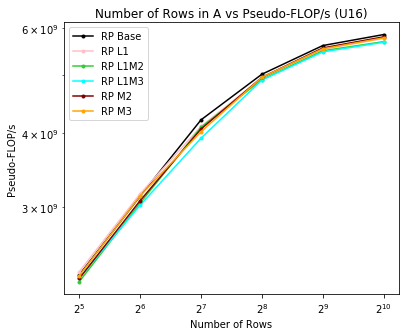

In [12]:
plt.figure(figsize=(6,5))

lm2_xvals, lm2_avg, _ = get_local_upstream_perf(lm2_runs, "vary_row/q_16", x_term="a_rows")
lm3_xvals, lm3_avg, _ = get_local_upstream_perf(lm3_runs, "vary_row/q_16", x_term="a_rows")
l1m_xvals, l1m2_avg, l1m3_avg = get_local_upstream_perf(l1m_runs, "vary_row/q_16", x_term="a_rows")

rp_xvals, rp_avg, _ = get_local_upstream_perf(rp_runs, "vary_row/q_16", x_term="a_rows")
plt.plot(rp_xvals, rp_avg, label="RP Base", color="black", marker=".")
rpl1_xvals, rpl1_avg, _ = get_local_upstream_perf(rpl1_runs, "vary_row/q_16", x_term="a_rows")
plt.plot(rpl1_xvals, rpl1_avg, label="RP L1", color="pink", marker=".")


plt.plot(l1m_xvals, l1m2_avg, label="RP L1M2", color="limegreen", marker=".")
plt.plot(l1m_xvals, l1m3_avg, label="RP L1M3", color="cyan", marker=".")

plt.plot(lm2_xvals, lm2_avg, label="RP M2", color="maroon", marker=".")
plt.plot(lm3_xvals, lm3_avg, label="RP M3", color="orange", marker=".")

plt.xlabel("Number of Rows")
plt.ylabel("Pseudo-FLOP/s")
plt.yscale("log", basey=10)
plt.xscale("log", basex=2)
plt.title("Number of Rows in A vs Pseudo-FLOP/s (U16)")
plt.legend()
plt.savefig("./../../../plots/regpack_L1_macc/l1m/synth/vary_row_16.pdf")
plt.show()

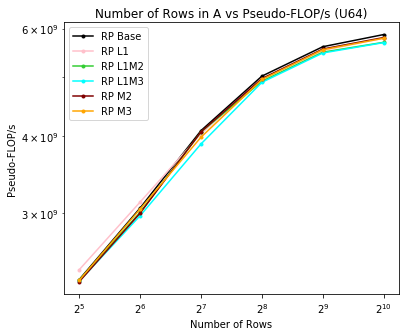

In [13]:
plt.figure(figsize=(6,5))

lm2_xvals, lm2_avg, _ = get_local_upstream_perf(lm2_runs, "vary_row/q_64", x_term="a_rows")
lm3_xvals, lm3_avg, _ = get_local_upstream_perf(lm3_runs, "vary_row/q_64", x_term="a_rows")
l1m_xvals, l1m2_avg, l1m3_avg = get_local_upstream_perf(l1m_runs, "vary_row/q_64", x_term="a_rows")

rp_xvals, rp_avg, _ = get_local_upstream_perf(rp_runs, "vary_row/q_64", x_term="a_rows")
plt.plot(rp_xvals, rp_avg, label="RP Base", color="black", marker=".")
rpl1_xvals, rpl1_avg, _ = get_local_upstream_perf(rpl1_runs, "vary_row/q_64", x_term="a_rows")
plt.plot(rpl1_xvals, rpl1_avg, label="RP L1", color="pink", marker=".")

plt.plot(l1m_xvals, l1m2_avg, label="RP L1M2", color="limegreen", marker=".")
plt.plot(l1m_xvals, l1m3_avg, label="RP L1M3", color="cyan", marker=".")

plt.plot(lm2_xvals, lm2_avg, label="RP M2", color="maroon", marker=".")
plt.plot(lm3_xvals, lm3_avg, label="RP M3", color="orange", marker=".")

plt.xlabel("Number of Rows")
plt.ylabel("Pseudo-FLOP/s")
plt.yscale("log", basey=10)
plt.xscale("log", basex=2)
plt.title("Number of Rows in A vs Pseudo-FLOP/s (U64)")
plt.legend()
plt.savefig("./../../../plots/regpack_L1_macc/l1m/synth/vary_row_64.pdf")
plt.show()

## Vary Columns

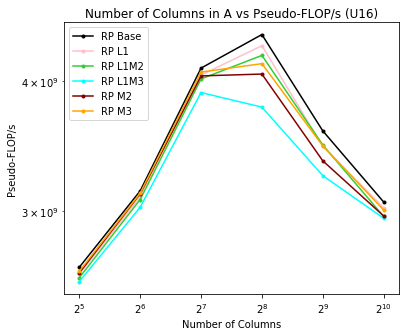

In [14]:
plt.figure(figsize=(6,5))

lm2_xvals, lm2_avg, _ = get_local_upstream_perf(lm2_runs, "vary_col/q_16", x_term="a_cols")
lm3_xvals, lm3_avg, _ = get_local_upstream_perf(lm3_runs, "vary_col/q_16", x_term="a_cols")
l1m_xvals, l1m2_avg, l1m3_avg = get_local_upstream_perf(l1m_runs, "vary_col/q_16", x_term="a_cols")

rp_xvals, rp_avg, _ = get_local_upstream_perf(rp_runs, "vary_col/q_16", x_term="a_cols")
plt.plot(rp_xvals, rp_avg, label="RP Base", color="black", marker=".")
rpl1_xvals, rpl1_avg, _ = get_local_upstream_perf(rpl1_runs, "vary_col/q_16", x_term="a_cols")
plt.plot(rpl1_xvals, rpl1_avg, label="RP L1", color="pink", marker=".")

plt.plot(l1m_xvals, l1m2_avg, label="RP L1M2", color="limegreen", marker=".")
plt.plot(l1m_xvals, l1m3_avg, label="RP L1M3", color="cyan", marker=".")

plt.plot(lm2_xvals, lm2_avg, label="RP M2", color="maroon", marker=".")
plt.plot(lm3_xvals, lm3_avg, label="RP M3", color="orange", marker=".")

plt.xlabel("Number of Columns")
plt.ylabel("Pseudo-FLOP/s")
plt.yscale("log", basey=10)
plt.xscale("log", basex=2)
plt.title("Number of Columns in A vs Pseudo-FLOP/s (U16)")
plt.legend()
plt.savefig("./../../../plots/regpack_L1_macc/l1m/synth/vary_cols_16.pdf")
plt.show()

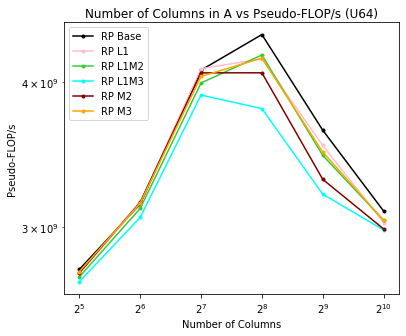

In [15]:
plt.figure(figsize=(6,5))

lm2_xvals, lm2_avg, _ = get_local_upstream_perf(lm2_runs, "vary_col/q_64", x_term="a_cols")
lm3_xvals, lm3_avg, _ = get_local_upstream_perf(lm3_runs, "vary_col/q_64", x_term="a_cols")
l1m_xvals, l1m2_avg, l1m3_avg = get_local_upstream_perf(l1m_runs, "vary_col/q_64", x_term="a_cols")

rp_xvals, rp_avg, _ = get_local_upstream_perf(rp_runs, "vary_col/q_64", x_term="a_cols")
plt.plot(rp_xvals, rp_avg, label="RP Base", color="black", marker=".")
rpl1_xvals, rpl1_avg, _ = get_local_upstream_perf(rpl1_runs, "vary_col/q_64", x_term="a_cols")
plt.plot(rpl1_xvals, rpl1_avg, label="RP L1", color="pink", marker=".")

plt.plot(l1m_xvals, l1m2_avg, label="RP L1M2", color="limegreen", marker=".")
plt.plot(l1m_xvals, l1m3_avg, label="RP L1M3", color="cyan", marker=".")

plt.plot(lm2_xvals, lm2_avg, label="RP M2", color="maroon", marker=".")
plt.plot(lm3_xvals, lm3_avg, label="RP M3", color="orange", marker=".")

plt.xlabel("Number of Columns")
plt.ylabel("Pseudo-FLOP/s")
plt.yscale("log", basey=10)
plt.xscale("log", basex=2)
plt.title("Number of Columns in A vs Pseudo-FLOP/s (U64)")
plt.legend()
plt.savefig("./../../../plots/regpack_L1_macc/l1m/synth/vary_cols_64.pdf")
plt.show()

## Vary Density

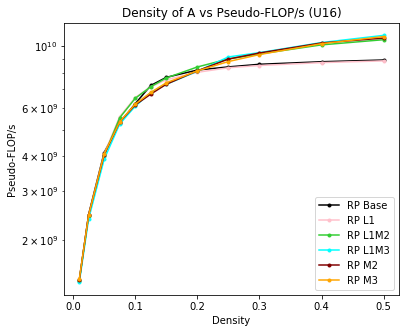

In [16]:
plt.figure(figsize=(6,5))

lm2_xvals, lm2_avg, _ = get_local_upstream_perf(lm2_runs, "vary_density/q_16", x_term="density")
lm3_xvals, lm3_avg, _ = get_local_upstream_perf(lm3_runs, "vary_density/q_16", x_term="density")
l1m_xvals, l1m2_avg, l1m3_avg = get_local_upstream_perf(l1m_runs, "vary_density/q_16", x_term="density")

rp_xvals, rp_avg, _ = get_local_upstream_perf(rp_runs, "vary_density/q_16", x_term="density")
plt.plot(rp_xvals, rp_avg, label="RP Base", color="black", marker=".")
rpl1_xvals, rpl1_avg, _ = get_local_upstream_perf(rpl1_runs, "vary_density/q_16", x_term="density")
plt.plot(rpl1_xvals, rpl1_avg, label="RP L1", color="pink", marker=".")

plt.plot(l1m_xvals, l1m2_avg, label="RP L1M2", color="limegreen", marker=".")
plt.plot(l1m_xvals, l1m3_avg, label="RP L1M3", color="cyan", marker=".")

plt.plot(lm2_xvals, lm2_avg, label="RP M2", color="maroon", marker=".")
plt.plot(lm3_xvals, lm3_avg, label="RP M3", color="orange", marker=".")

plt.xlabel("Density")
plt.ylabel("Pseudo-FLOP/s")
plt.yscale("log", basey=10)
plt.title("Density of A vs Pseudo-FLOP/s (U16)")
plt.legend()
plt.savefig("./../../../plots/regpack_L1_macc/l1m/synth/vary_density_16.pdf")
plt.show()

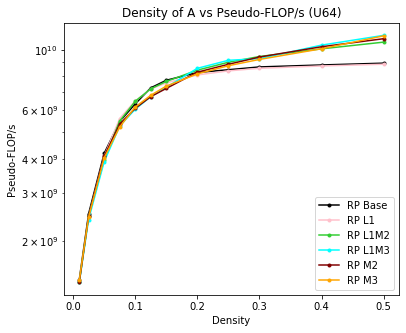

In [17]:
plt.figure(figsize=(6,5))

lm2_xvals, lm2_avg, _ = get_local_upstream_perf(lm2_runs, "vary_density/q_64", x_term="density")
lm3_xvals, lm3_avg, _ = get_local_upstream_perf(lm3_runs, "vary_density/q_64", x_term="density")
l1m_xvals, l1m2_avg, l1m3_avg = get_local_upstream_perf(l1m_runs, "vary_density/q_64", x_term="density")

rp_xvals, rp_avg, _ = get_local_upstream_perf(rp_runs, "vary_density/q_64", x_term="density")
plt.plot(rp_xvals, rp_avg, label="RP Base", color="black", marker=".")
rpl1_xvals, rpl1_avg, _ = get_local_upstream_perf(rpl1_runs, "vary_density/q_64", x_term="density")
plt.plot(rpl1_xvals, rpl1_avg, label="RP L1", color="pink", marker=".")

plt.plot(l1m_xvals, l1m2_avg, label="RP L1M2", color="limegreen", marker=".")
plt.plot(l1m_xvals, l1m3_avg, label="RP L1M3", color="cyan", marker=".")

plt.plot(lm2_xvals, lm2_avg, label="RP M2", color="maroon", marker=".")
plt.plot(lm3_xvals, lm3_avg, label="RP M3", color="orange", marker=".")

plt.xlabel("Density")
plt.ylabel("Pseudo-FLOP/s")
plt.yscale("log", basey=10)
plt.title("Density of A vs Pseudo-FLOP/s (U64)")
plt.legend()
plt.savefig("./../../../plots/regpack_L1_macc/l1m/synth/vary_density_64.pdf")
plt.show()

## Vary Num Unique

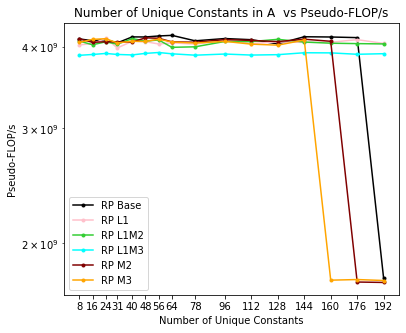

In [18]:
plt.figure(figsize=(6,5))

lm2_xvals, lm2_avg, _ = get_local_upstream_perf(lm2_runs, "vary_unique", x_term="a_unique")
lm3_xvals, lm3_avg, _ = get_local_upstream_perf(lm3_runs, "vary_unique", x_term="a_unique")
l1m_xvals, l1m2_avg, l1m3_avg = get_local_upstream_perf(l1m_runs, "vary_unique", x_term="a_unique")

rp_xvals, rp_avg, _ = get_local_upstream_perf(rp_runs, "vary_unique", x_term="a_unique")
plt.plot(rp_xvals, rp_avg, label="RP Base", color="black", marker=".")
rpl1_xvals, rpl1_avg, _ = get_local_upstream_perf(rpl1_runs, "vary_unique", x_term="a_unique")
plt.plot(rpl1_xvals, rpl1_avg, label="RP L1", color="pink", marker=".")

plt.plot(l1m_xvals, l1m2_avg, label="RP L1M2", color="limegreen", marker=".")
plt.plot(l1m_xvals, l1m3_avg, label="RP L1M3", color="cyan", marker=".")

plt.plot(lm2_xvals, lm2_avg, label="RP M2", color="maroon", marker=".")
plt.plot(lm3_xvals, lm3_avg, label="RP M3", color="orange", marker=".")

plt.xlabel("Number of Unique Constants")
plt.ylabel("Pseudo-FLOP/s")
plt.yscale("log", basey=10)
plt.xticks(lm2_xvals)
plt.title("Number of Unique Constants in A  vs Pseudo-FLOP/s")
plt.legend()
plt.savefig("./../../../plots/regpack_L1_macc/l1m/synth/vary_unique.pdf")
plt.show()

# LN Blocking

## Vary Rows

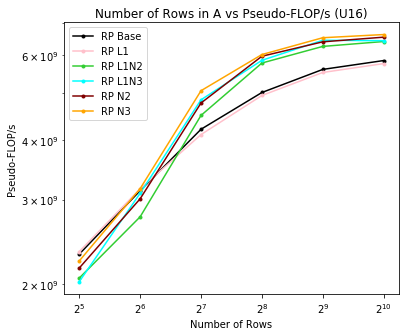

In [20]:
plt.figure(figsize=(6,5))

ln2_xvals, ln2_avg, _ = get_local_upstream_perf(ln2_runs, "vary_row/q_16", x_term="a_rows")
ln3_xvals, ln3_avg, _ = get_local_upstream_perf(ln3_runs, "vary_row/q_16", x_term="a_rows")
l1n_xvals, l1n2_avg, l1n3_avg = get_local_upstream_perf(l1n_runs, "vary_row/q_16", x_term="a_rows")

rp_xvals, rp_avg, _ = get_local_upstream_perf(rp_runs, "vary_row/q_16", x_term="a_rows")
plt.plot(rp_xvals, rp_avg, label="RP Base", color="black", marker=".")
rpl1_xvals, rpl1_avg, _ = get_local_upstream_perf(rpl1_runs, "vary_row/q_16", x_term="a_rows")
plt.plot(rpl1_xvals, rpl1_avg, label="RP L1", color="pink", marker=".")


plt.plot(l1n_xvals, l1n2_avg, label="RP L1N2", color="limegreen", marker=".")
plt.plot(l1n_xvals, l1n3_avg, label="RP L1N3", color="cyan", marker=".")

plt.plot(ln2_xvals, ln2_avg, label="RP N2", color="maroon", marker=".")
plt.plot(ln3_xvals, ln3_avg, label="RP N3", color="orange", marker=".")

plt.xlabel("Number of Rows")
plt.ylabel("Pseudo-FLOP/s")
plt.yscale("log", basey=10)
plt.xscale("log", basex=2)
plt.title("Number of Rows in A vs Pseudo-FLOP/s (U16)")
plt.legend()
plt.savefig("./../../../plots/regpack_L1_macc/l1n/synth/vary_row_16.pdf")
plt.show()

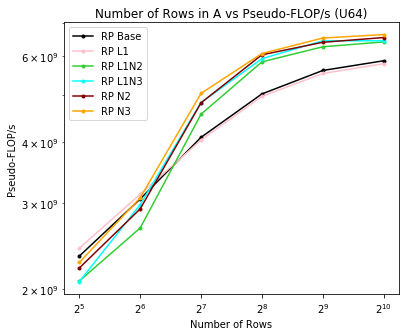

In [21]:
plt.figure(figsize=(6,5))

ln2_xvals, ln2_avg, _ = get_local_upstream_perf(ln2_runs, "vary_row/q_64", x_term="a_rows")
ln3_xvals, ln3_avg, _ = get_local_upstream_perf(ln3_runs, "vary_row/q_64", x_term="a_rows")
l1n_xvals, l1n2_avg, l1n3_avg = get_local_upstream_perf(l1n_runs, "vary_row/q_64", x_term="a_rows")

rp_xvals, rp_avg, _ = get_local_upstream_perf(rp_runs, "vary_row/q_64", x_term="a_rows")
plt.plot(rp_xvals, rp_avg, label="RP Base", color="black", marker=".")
rpl1_xvals, rpl1_avg, _ = get_local_upstream_perf(rpl1_runs, "vary_row/q_64", x_term="a_rows")
plt.plot(rpl1_xvals, rpl1_avg, label="RP L1", color="pink", marker=".")

plt.plot(l1n_xvals, l1n2_avg, label="RP L1N2", color="limegreen", marker=".")
plt.plot(l1n_xvals, l1n3_avg, label="RP L1N3", color="cyan", marker=".")

plt.plot(ln2_xvals, ln2_avg, label="RP N2", color="maroon", marker=".")
plt.plot(ln3_xvals, ln3_avg, label="RP N3", color="orange", marker=".")

plt.xlabel("Number of Rows")
plt.ylabel("Pseudo-FLOP/s")
plt.yscale("log", basey=10)
plt.xscale("log", basex=2)
plt.title("Number of Rows in A vs Pseudo-FLOP/s (U64)")
plt.legend()
plt.savefig("./../../../plots/regpack_L1_macc/l1n/synth/vary_row_64.pdf")
plt.show()

## Vary Columns

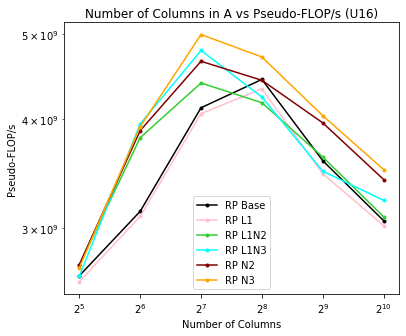

In [22]:
plt.figure(figsize=(6,5))

ln2_xvals, ln2_avg, _ = get_local_upstream_perf(ln2_runs, "vary_col/q_16", x_term="a_cols")
ln3_xvals, ln3_avg, _ = get_local_upstream_perf(ln3_runs, "vary_col/q_16", x_term="a_cols")
l1n_xvals, l1n2_avg, l1n3_avg = get_local_upstream_perf(l1n_runs, "vary_col/q_16", x_term="a_cols")

rp_xvals, rp_avg, _ = get_local_upstream_perf(rp_runs, "vary_col/q_16", x_term="a_cols")
plt.plot(rp_xvals, rp_avg, label="RP Base", color="black", marker=".")
rpl1_xvals, rpl1_avg, _ = get_local_upstream_perf(rpl1_runs, "vary_col/q_16", x_term="a_cols")
plt.plot(rpl1_xvals, rpl1_avg, label="RP L1", color="pink", marker=".")

plt.plot(l1n_xvals, l1n2_avg, label="RP L1N2", color="limegreen", marker=".")
plt.plot(l1n_xvals, l1n3_avg, label="RP L1N3", color="cyan", marker=".")

plt.plot(ln2_xvals, ln2_avg, label="RP N2", color="maroon", marker=".")
plt.plot(ln3_xvals, ln3_avg, label="RP N3", color="orange", marker=".")

plt.xlabel("Number of Columns")
plt.ylabel("Pseudo-FLOP/s")
plt.yscale("log", basey=10)
plt.xscale("log", basex=2)
plt.title("Number of Columns in A vs Pseudo-FLOP/s (U16)")
plt.legend()
plt.savefig("./../../../plots/regpack_L1_macc/l1n/synth/vary_cols_16.pdf")
plt.show()

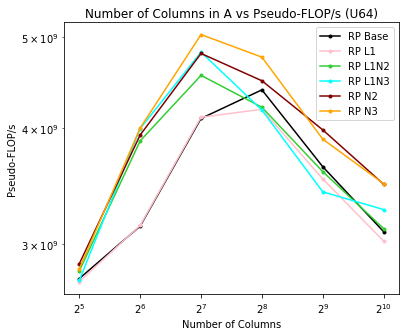

In [23]:
plt.figure(figsize=(6,5))

ln2_xvals, ln2_avg, _ = get_local_upstream_perf(ln2_runs, "vary_col/q_64", x_term="a_cols")
ln3_xvals, ln3_avg, _ = get_local_upstream_perf(ln3_runs, "vary_col/q_64", x_term="a_cols")
l1n_xvals, l1n2_avg, l1n3_avg = get_local_upstream_perf(l1n_runs, "vary_col/q_64", x_term="a_cols")

rp_xvals, rp_avg, _ = get_local_upstream_perf(rp_runs, "vary_col/q_64", x_term="a_cols")
plt.plot(rp_xvals, rp_avg, label="RP Base", color="black", marker=".")
rpl1_xvals, rpl1_avg, _ = get_local_upstream_perf(rpl1_runs, "vary_col/q_64", x_term="a_cols")
plt.plot(rpl1_xvals, rpl1_avg, label="RP L1", color="pink", marker=".")


plt.plot(l1n_xvals, l1n2_avg, label="RP L1N2", color="limegreen", marker=".")
plt.plot(l1n_xvals, l1n3_avg, label="RP L1N3", color="cyan", marker=".")

plt.plot(ln2_xvals, ln2_avg, label="RP N2", color="maroon", marker=".")
plt.plot(ln3_xvals, ln3_avg, label="RP N3", color="orange", marker=".")

plt.xlabel("Number of Columns")
plt.ylabel("Pseudo-FLOP/s")
plt.yscale("log", basey=10)
plt.xscale("log", basex=2)
plt.title("Number of Columns in A vs Pseudo-FLOP/s (U64)")
plt.legend()
plt.savefig("./../../../plots/regpack_L1_macc/l1n/synth/vary_cols_64.pdf")
plt.show()

## Vary Density

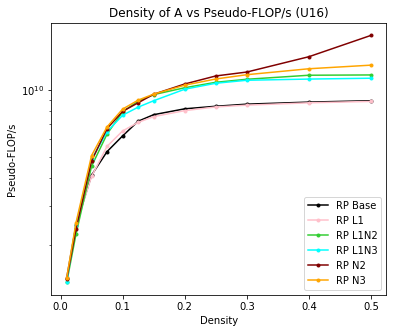

In [24]:
plt.figure(figsize=(6,5))

ln2_xvals, ln2_avg, _ = get_local_upstream_perf(ln2_runs, "vary_density/q_16", x_term="density")
ln3_xvals, ln3_avg, _ = get_local_upstream_perf(ln3_runs, "vary_density/q_16", x_term="density")
l1n_xvals, l1n2_avg, l1n3_avg = get_local_upstream_perf(l1n_runs, "vary_density/q_16", x_term="density")

rp_xvals, rp_avg, _ = get_local_upstream_perf(rp_runs, "vary_density/q_16", x_term="density")
plt.plot(rp_xvals, rp_avg, label="RP Base", color="black", marker=".")
rpl1_xvals, rpl1_avg, _ = get_local_upstream_perf(rpl1_runs, "vary_density/q_16", x_term="density")
plt.plot(rpl1_xvals, rpl1_avg, label="RP L1", color="pink", marker=".")

plt.plot(l1n_xvals, l1n2_avg, label="RP L1N2", color="limegreen", marker=".")
plt.plot(l1n_xvals, l1n3_avg, label="RP L1N3", color="cyan", marker=".")

plt.plot(ln2_xvals, ln2_avg, label="RP N2", color="maroon", marker=".")
plt.plot(ln3_xvals, ln3_avg, label="RP N3", color="orange", marker=".")

plt.xlabel("Density")
plt.ylabel("Pseudo-FLOP/s")
plt.yscale("log", basey=10)
plt.title("Density of A vs Pseudo-FLOP/s (U16)")
plt.legend()
plt.savefig("./../../../plots/regpack_L1_macc/l1n/synth/vary_density_16.pdf")
plt.show()

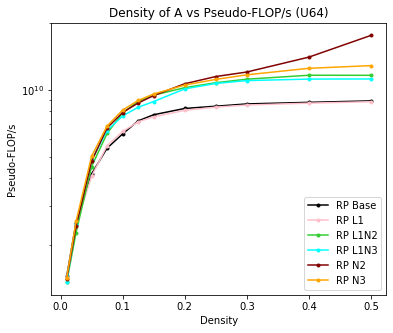

In [25]:
plt.figure(figsize=(6,5))

ln2_xvals, ln2_avg, _ = get_local_upstream_perf(ln2_runs, "vary_density/q_64", x_term="density")
ln3_xvals, ln3_avg, _ = get_local_upstream_perf(ln3_runs, "vary_density/q_64", x_term="density")
l1n_xvals, l1n2_avg, l1n3_avg = get_local_upstream_perf(l1n_runs, "vary_density/q_64", x_term="density")

rp_xvals, rp_avg, _ = get_local_upstream_perf(rp_runs, "vary_density/q_64", x_term="density")
plt.plot(rp_xvals, rp_avg, label="RP Base", color="black", marker=".")
rpl1_xvals, rpl1_avg, _ = get_local_upstream_perf(rpl1_runs, "vary_density/q_64", x_term="density")
plt.plot(rpl1_xvals, rpl1_avg, label="RP L1", color="pink", marker=".")

plt.plot(l1n_xvals, l1n2_avg, label="RP L1N2", color="limegreen", marker=".")
plt.plot(l1n_xvals, l1n3_avg, label="RP L1N3", color="cyan", marker=".")

plt.plot(ln2_xvals, ln2_avg, label="RP N2", color="maroon", marker=".")
plt.plot(ln3_xvals, ln3_avg, label="RP N3", color="orange", marker=".")

plt.xlabel("Density")
plt.ylabel("Pseudo-FLOP/s")
plt.yscale("log", basey=10)
plt.title("Density of A vs Pseudo-FLOP/s (U64)")
plt.legend()
plt.savefig("./../../../plots/regpack_L1_macc/l1n/synth/vary_density_64.pdf")
plt.show()

## Vary Num Unique

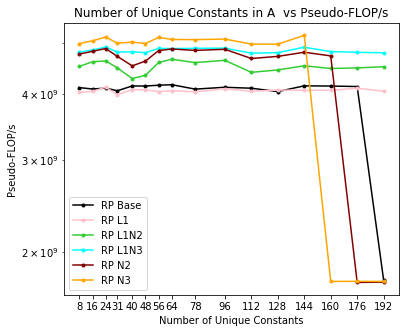

In [26]:
plt.figure(figsize=(6,5))

ln2_xvals, ln2_avg, _ = get_local_upstream_perf(ln2_runs, "vary_unique", x_term="a_unique")
ln3_xvals, ln3_avg, _ = get_local_upstream_perf(ln3_runs, "vary_unique", x_term="a_unique")
l1n_xvals, l1n2_avg, l1n3_avg = get_local_upstream_perf(l1n_runs, "vary_unique", x_term="a_unique")

rp_xvals, rp_avg, _ = get_local_upstream_perf(rp_runs, "vary_unique", x_term="a_unique")
plt.plot(rp_xvals, rp_avg, label="RP Base", color="black", marker=".")
rpl1_xvals, rpl1_avg, _ = get_local_upstream_perf(rpl1_runs, "vary_unique", x_term="a_unique")
plt.plot(rpl1_xvals, rpl1_avg, label="RP L1", color="pink", marker=".")

plt.plot(l1n_xvals, l1n2_avg, label="RP L1N2", color="limegreen", marker=".")
plt.plot(l1n_xvals, l1n3_avg, label="RP L1N3", color="cyan", marker=".")

plt.plot(ln2_xvals, ln2_avg, label="RP N2", color="maroon", marker=".")
plt.plot(ln3_xvals, ln3_avg, label="RP N3", color="orange", marker=".")
plt.xlabel("Number of Unique Constants")
plt.ylabel("Pseudo-FLOP/s")
plt.yscale("log", basey=10)
plt.xticks(ln2_xvals)
plt.title("Number of Unique Constants in A  vs Pseudo-FLOP/s")
plt.legend()
plt.savefig("./../../../plots/regpack_L1_macc/l1n/synth/vary_unique.pdf")
plt.show()